In [9]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
import warnings
from scipy.stats import describe
import pandas as pd
from bayes_opt import BayesianOptimization
from astropy.stats import sigma_clip
from scipy.stats import ks_2samp
from PIL import Image as im
import cv2
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from scale import scale_M
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from scipy.interpolate import NearestNDInterpolator
import scipy
import unet as un
import torch
import config
from makedataset import make_dataset

warnings.filterwarnings("ignore")

In [1]:
from makedataset import make_dataset

In [2]:
make_dataset(n_crops = 5)

In [1492]:
net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'transinet_crts.caffemodel')

In [2]:
# SkyCoord('00h20m52s', '+07d49m33s', frame='icrs')
k = 2
M_hdu = fits.open('data/prepro/'+str(k)+'_M.fits')[0]
M_wcs = WCS(M_hdu.header)
M = M_hdu.data
P = fits.open('data/prepro/'+str(k)+'_P.fits')[0].data

In [13]:
for k in range(5):
    h = fits.open('data/prepro/'+str(k)+'_M.fits')[0].header
    print( h['EXPTIME'], h['NCOMBINE'])

300.0 12
300.0 14
300.0 10
300.0 8
300.0 14


In [3]:
boffset, median, bsoften = sigma_clipped_stats(M[200:1896, 200:1896].copy(), maxiters=0)

In [4]:
%%time

offset, soft = scale_M(16,
              64,
              M,
              P,
              boffset,
              bsoften,)

a = 2.5*np.log10(2.718281)
M_scaled = a*np.arcsinh((M - offset*boffset)/(soft*bsoften*np.sqrt(a)))

CPU times: user 50.6 s, sys: 12.6 s, total: 1min 3s
Wall time: 29.3 s


In [5]:
md_mean, md_median, md_std = sigma_clipped_stats(M_scaled)
ps_mean, ps_median, ps_std = sigma_clipped_stats(P)

In [6]:
# SkyCoord('00h20m52s', '+07d49m33s', frame='icrs')
world = SkyCoord(M_hdu.header['RA'] + ' ' + M_hdu.header['DEC'], unit=(u.hourangle, u.deg))
grb = np.asarray(M_wcs.world_to_pixel(world))
print(M_hdu.header['OBJECT'], '\n', world, '\n', grb)

GRB210210A 
 <SkyCoord (ICRS): (ra, dec) in deg
    (262.77083333, 14.66272222)> 
 [1698.5927673  2422.60614171]


In [24]:
# y0 = int(grb[0]) + np.random.randint(-1000,1000)
# x0 = int(grb[1]) + np.random.randint(-1000,1000)

y0 = np.random.randint(200,3896)
x0 = np.random.randint(200,3896)

# y0 = int(grb[0])
# x0 = int(grb[1])

# M_crop = M_scaled[x0-128:x0+128, y0-128:y0+128].copy()
# P_crop = P[x0-128:x0+128, y0-128:y0+128].copy()

M_crop = M_scaled[x0-64:x0+64, y0-64:y0+64].copy()
P_crop = P[x0-64:x0+64, y0-64:y0+64].copy()

# M_crop = M[200:1896, 200:1896]
# P_crop = P[200:1896, 200:1896]

# M_crop = M.copy()
# P_crop = P.copy()

Доля пропущенных значений MD: 0.0%
Доля пропущенных значений PS: 0.0%


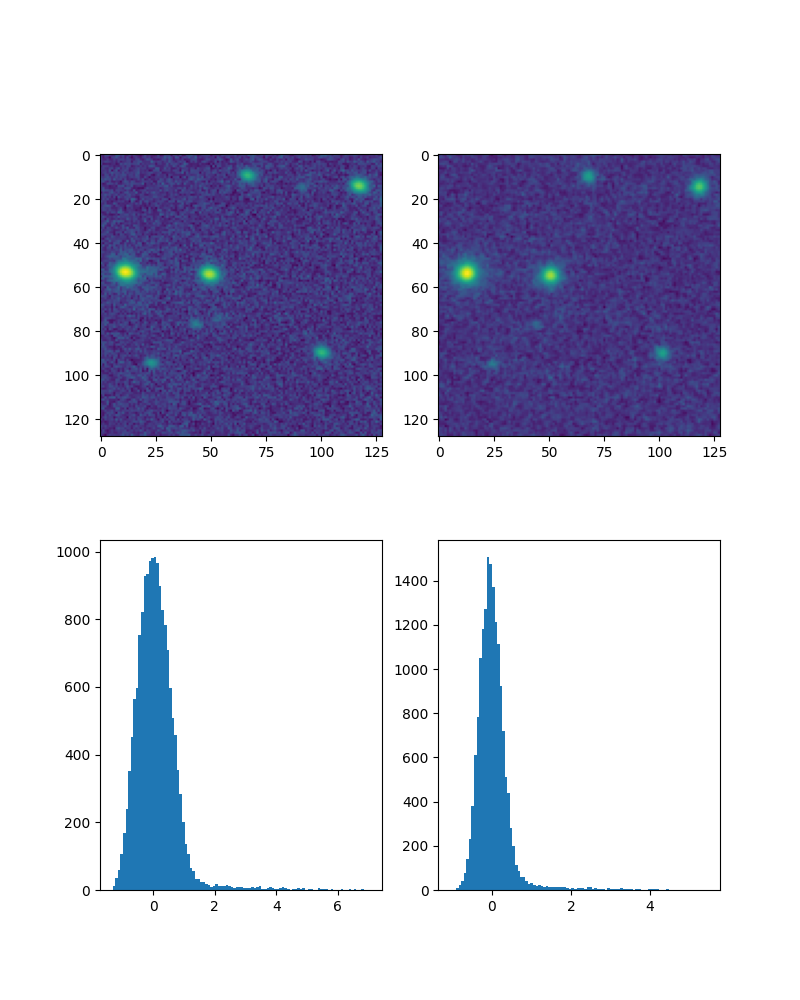

In [25]:
fig, ax = plt.subplots(2,2,figsize=(8,10))

ax[0][0].imshow(M_crop)

# ax[0][0].axvline(x=128, alpha=.5, lw=.5, c='k')
# ax[0][0].axhline(y=128, alpha=.5, lw=.5, c='k')

ax[0][1].imshow(P_crop)

a,b,c=ax[1][0].hist(M_crop.ravel(), bins=100)
a,b,c=ax[1][1].hist(P_crop.ravel(), bins=100)

m_nan_ratio = np.count_nonzero(1*np.isnan(M_crop.ravel()))/len(M_crop.ravel())*100
p_nan_ratio = np.count_nonzero(1*np.isnan(P_crop.ravel()))/len(P_crop.ravel())*100

print('Доля пропущенных значений MD: {}%'.format(m_nan_ratio))
print('Доля пропущенных значений PS: {}%'.format(p_nan_ratio))

In [26]:
md_threshold = md_median + (4.5*md_std)
ps_threshold = ps_median + (4.5*ps_std)

try:
    md_tbl = find_peaks(M_crop, md_threshold, box_size=20).as_array()
    ps_tbl = find_peaks(P_crop, ps_threshold, box_size=20).as_array()
    
    print(len(md_tbl) == len(ps_tbl))
    
except AttributeError:
    print('No source')

True


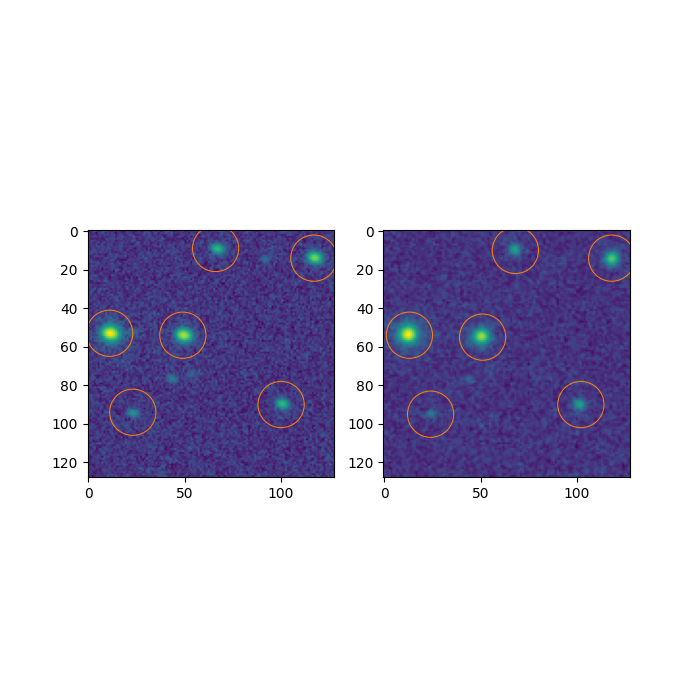

In [27]:
%matplotlib ipympl

fig, axs = plt.subplots(1,2,figsize=(7,7))

m_positions = np.transpose((md_tbl ['x_peak'], md_tbl ['y_peak']))
m_apertures = CircularAperture(m_positions, r=12.0)

p_positions = np.transpose((ps_tbl ['x_peak'], ps_tbl ['y_peak']))
p_apertures = CircularAperture(p_positions, r=12.0)

axs[0].imshow(M_crop)
axs[1].imshow(P_crop)

a = m_apertures.plot(axs[0], color='C1', lw=.75, alpha=1)
b = p_apertures.plot(axs[1],color='C1', lw=.75, alpha=1)

In [28]:
pos = ps_tbl[ps_tbl['peak_value'].argmax()]

try:
    padded = np.pad(P_crop, (2,2), mode='edge')
    img = padded[pos[1]:pos[1]+4, pos[0]:pos[0]+4]
    print((img.max()/img.min() < 3) & (img.min()>0))
except ValueError:
    print('False')

True


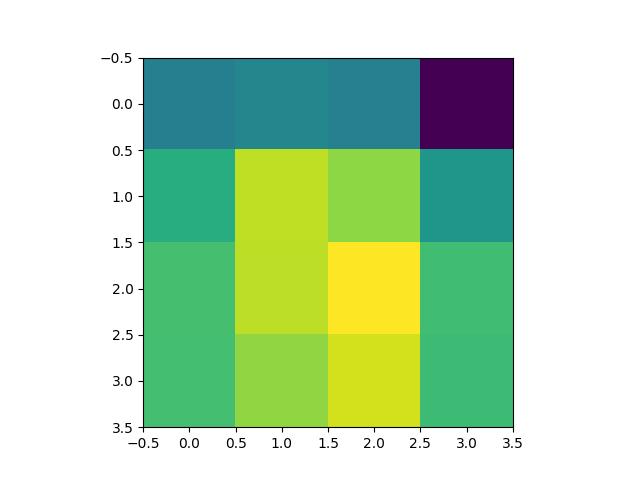

In [1481]:
fig, ax = plt.subplots()

ax.imshow(img)

In [262]:
try:
    img = P_crop[pos[1]-3:pos[1]+3, pos[0]-3:pos[0]+3]
    print(img.max()/img.min() > 4)
except ValueError:
    pass

False


In [12]:
m_thrhlds = np.linspace(1, 12, 36)
p_thrhlds = np.linspace(1, 12, 36)

In [14]:
%%time 

m_means = []
p_means = []

for i in range(36):
    m_thrhld = m_thrhlds[i]
    p_thrhld = p_thrhlds[i]

    m_sources = []
    p_sources = []

    y = 256
    x = 256

    while y < M_scaled.shape[0] - 256:

        while x < M_scaled.shape[0] - 256:

            M_crop, P_crop = M_scaled[y-128:y+128, x-128:x+128], P[y-128:y+128, x-128:x+128]

            md_threshold = md_median + (m_thrhld*md_std)
            ps_threshold = ps_median + (p_thrhld*ps_std)
            
            try:
                md_tbl = find_peaks(M_crop, md_threshold, box_size=20).as_array()
                m_sources.append(len(md_tbl))
                
            except AttributeError:
                m_sources.append(0)
                
            try:
                ps_tbl = find_peaks(P_crop, ps_threshold, box_size=20).as_array()
                p_sources.append(len(ps_tbl))
                
            except AttributeError:
                p_sources.append(0)

            x += 256

        y += 256
        x = 128

    m_means.append(np.array((m_sources)).mean())
    p_means.append(np.array((p_sources)).mean())

Wall time: 49.3 s


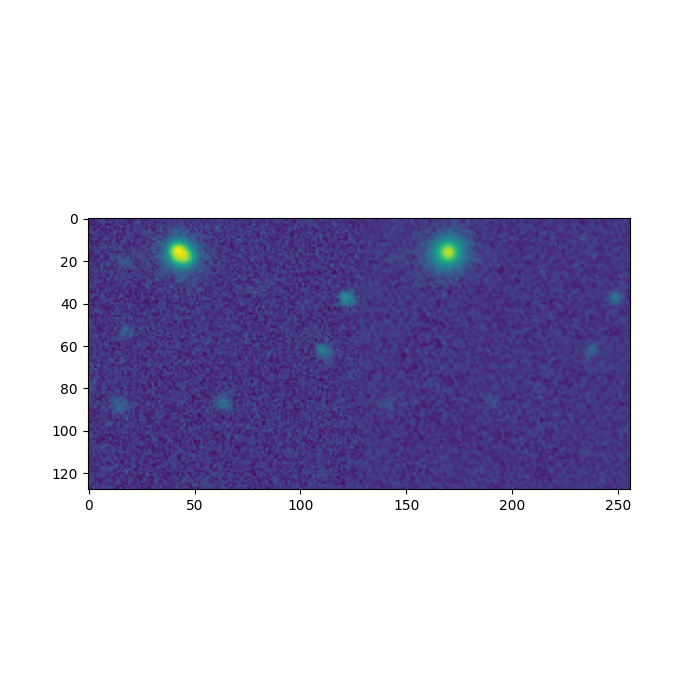

In [101]:
fig, ax = plt.subplots(figsize=(7,7))

m = np.random.randint(0,200)
ax.imshow(np.loadtxt('data_128/val/' + str(m) + '.txt'))

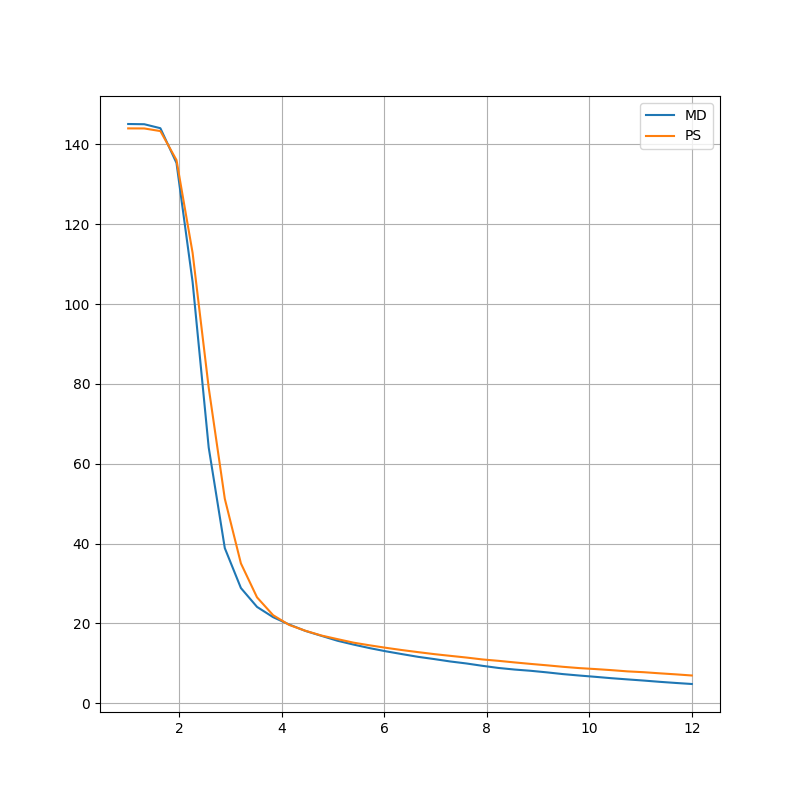

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(m_thrhlds, m_means, label='MD')
ax.plot(p_thrhlds, p_means, label='PS')
ax.grid()
ax.legend()

In [142]:
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus

position = [(127, 126)]
aperture = CircularAperture(position, r=10)
annulus = CircularAnnulus(position, r_in=10, r_out=20)

In [143]:
aperture_mask = aperture.to_mask(method='exact')
annulus_mask = annulus.to_mask(method='exact')

In [144]:
annulus_data = annulus_mask[0].multiply(M_scaled)
aperture_data = aperture_mask[0].multiply(M_scaled - annulus_data.mean())

In [30]:
# fig, ax = plt.subplots(figsize=(5,5))

# ax.imshow(aperture_data)

In [166]:
%%time

plus = np.zeros((P_crop.shape))
res = []
w = int(aperture_data.shape[0])

for i in range(plus.shape[0] - w):
    for j in range(plus.shape[1] - w):
        plus = np.zeros((P_crop.shape))
        plus[i:i+w, j:j+w] = aperture_data
        P_plus = P_crop.copy() + plus
        cf = get_corcoef(M_scaled, P_plus)
        res.append([i,j, cf])
        
#         to_save -= to_save.min()
#         to_save /= to_save.max()
#         plt.imsave('animation/' + str(i) + '_' + str(j) + '.png', 255*to_save)

Wall time: 30.5 s


In [167]:
result = np.array((res))

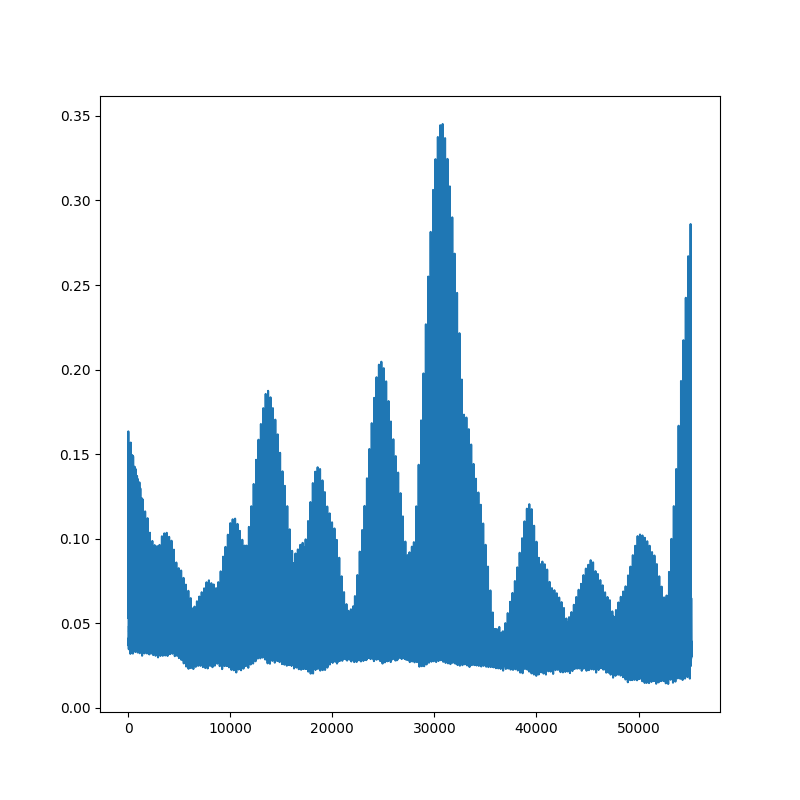

In [168]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(result[:, 2])

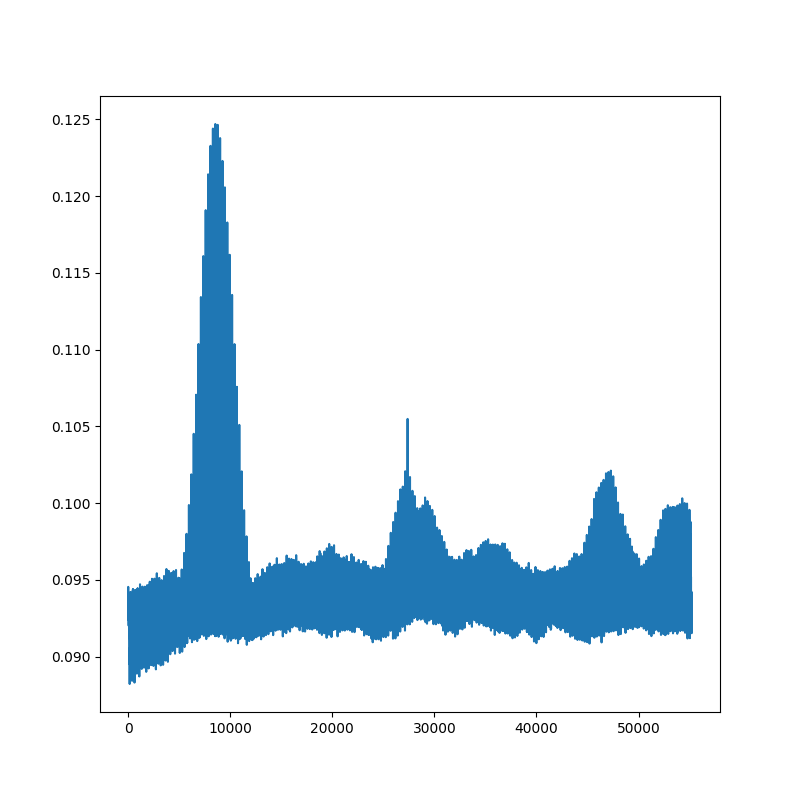

In [150]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(result[:, 2])

In [169]:
corr = result[:, 2][:256 - w].reshape(1,-1)

for k in range(1, 256 - w):
    corr = np.concatenate((corr, result[:,2][(256 - w)*k:256 - w+(256 - w)*k].reshape(1,-1)), axis=0)

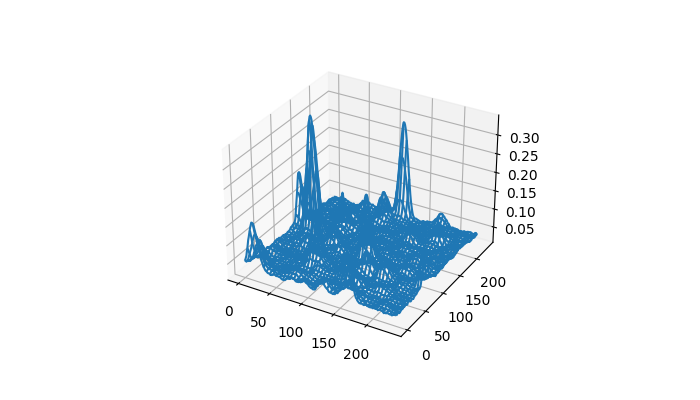

In [170]:
fig = plt.figure(figsize=(7, 4))
ax_3d = fig.add_subplot(projection='3d')

x = np.arange(0, 256 - w)
y = np.arange(0, 256 - w)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = corr

ax_3d.plot_wireframe(xgrid, ygrid, zgrid)

In [171]:
M_scaled -= M_scaled.min()
M_scaled /= M_scaled.max()
M_scaled *= 255

P_crop -= P_crop.min()
P_crop /= P_crop.max()
P_crop *= 255

M_data = im.fromarray((M_scaled).astype(np.uint8))
M_data.save('M_im.jpeg')
M_im = cv2.imread('M_im.jpeg')
M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

P_data = im.fromarray((P_crop).astype(np.uint8))
P_data.save('P_im.jpeg')
P_im = cv2.imread('P_im.jpeg')
P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

4


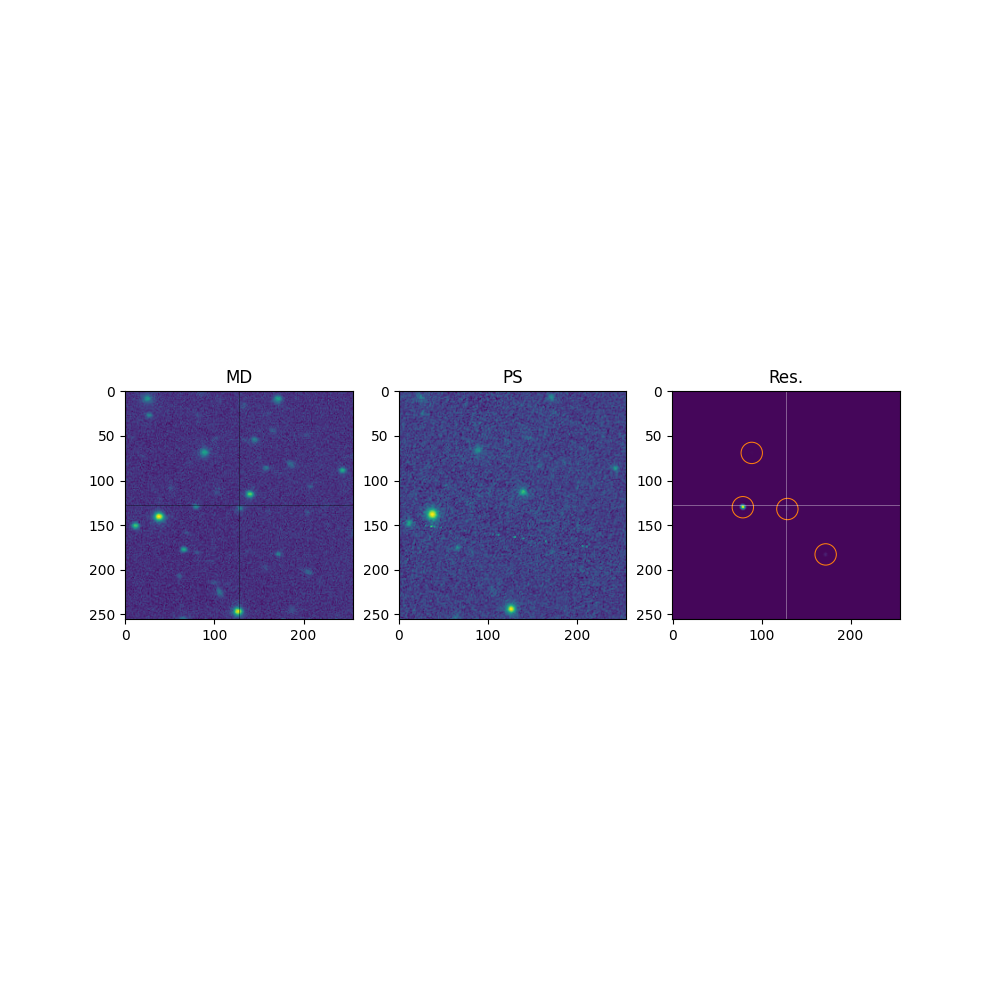

In [172]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(10, 10))

inp1 = cv2.dnn.blobFromImage(P_img, 1, (256,256))
inp2 = cv2.dnn.blobFromImage(M_img, 1, (256,256))

net.setInput(inp1, 'img0')
net.setInput(inp2, 'img1')

out = net.forward()
std = out.std()

# out[0][0][out[0][0] < np.sqrt(std)/100] = 0
# out[0][0][out[0][0] >= np.sqrt(std)/100] = 1

ax1.imshow(M_img)
ax1.axvline(x=128, alpha = .5, lw=.5, c='k')
ax1.axhline(y=128, alpha = .5, lw=.5, c='k')

ax1.set_title('MD')

ax2.imshow(P_img)
ax2.set_title('PS')

ax3.imshow(out[0][0])
ax3.axvline(x=128, alpha = .5, c='white', lw=.5)
ax3.axhline(y=128, alpha = .5, c='white', lw=.5)

ax3.set_title('Res.')

out_mean, out_median, out_std = sigma_clipped_stats(out[0][0])

out_threshold = out_median + (75*out_std)
out_tbl = find_peaks(out[0][0], out_threshold, box_size=25).as_array()

out_positions = np.transpose((out_tbl ['x_peak'], out_tbl ['y_peak']))
out_apertures = CircularAperture(out_positions, r=12.0)
a = out_apertures.plot(ax3, color='C1', lw=.75, alpha=1)
print(len(out_tbl))

In [282]:
%%time

def extraction_loss(m_sigma,
                    m_maxiters,
                    m_thrhld,
                    p_sigma,
                    p_maxiters,
                    p_thrhld,
                    M = M_scaled,
                    P = P_crop):
    
        md_mean, md_median, md_std = sigma_clipped_stats(M,
                                                         sigma=m_sigma,
                                                         maxiters=m_maxiters)
        
        ps_mean, ps_median, ps_std = sigma_clipped_stats(P,
                                                         sigma=p_sigma,
                                                         maxiters=p_maxiters)

        md_threshold = md_median + (m_thrhld*md_std)
        ps_threshold = ps_median + (p_thrhld*ps_std)

        md_tbl = find_peaks(M, md_threshold, box_size=20).as_array()
        ps_tbl = find_peaks(P, ps_threshold, box_size=20).as_array()
    
        return -np.abs(len(md_tbl) - len(ps_tbl))
    
    
pbounds = {'m_sigma': (1, 7),
           'm_maxiters': (0, 5),
           'm_thrhld': (1, 5),
           'p_sigma': (1, 7),
           'p_maxiters': (0, 5),
           'p_thrhld': (1, 5),
          }

optimizer = BayesianOptimization(

    f=extraction_loss, 
    pbounds=pbounds,
    random_state=1,
    verbose=True
)

optimizer.maximize(
    init_points=20,
    n_iter=20
)

m_sigma = optimizer.max['params']['m_sigma']
m_maxiters = optimizer.max['params']['m_maxiters']
m_thrhld = optimizer.max['params']['m_thrhld']
p_sigma = optimizer.max['params']['p_sigma']
p_maxiters = optimizer.max['params']['p_maxiters']
p_thrhld = optimizer.max['params']['p_thrhld']

|   iter    |  target   | m_maxi... |  m_sigma  | m_thrhld  | p_maxi... |  p_sigma  | p_thrhld  |
-------------------------------------------------------------------------------------------------
| 33        | 0.0       | 1.389     | 1.0       | 1.0       | 4.889     | 1.0       | 1.0       |


KeyboardInterrupt: 

In [82]:
md_mean, md_median, md_std = sigma_clipped_stats(M_scaled)
ps_mean, ps_median, ps_std = sigma_clipped_stats(P_crop)

md_threshold = md_median + (3*md_std)
ps_threshold = ps_median + (3*ps_std)
    
md_tbl = find_peaks(M_scaled, md_threshold, box_size=20).as_array()
ps_tbl = find_peaks(P_crop, ps_threshold, box_size=20).as_array()
print(len(md_tbl), len(ps_tbl))

36 52


In [334]:
m_thrhlds = np.linspace(1, 12, 36)
p_thrhlds = np.linspace(1, 12, 36)

In [335]:
m_thrhlds = np.linspace(1, 12, 36)
p_thrhlds = np.linspace(1, 12, 36)

%%time 

m_means = []
p_means = []

for i in range(36):
    m_thrhld = m_thrhlds[i]
    p_thrhld = p_thrhlds[i]

    m_sources = []
    p_sources = []

    y = 128
    x = 128

    boffset, ps_median, bsoften = sigma_clipped_stats(M[200:1896, 200:1896], maxiters=0)

    while y < 1024:

        while x < 1024:

            M_crop, P_crop = M[y-128:y+128, x-128:x+128], P[y-128:y+128, x-128:x+128]

            M_scaled = scale_M(10,
                  10,
                  M_crop,
                  P_crop,
                  bsoften,
                  boffset,)

            md_mean, md_median, md_std = sigma_clipped_stats(M_scaled,
                                                     sigma=3,
                                                     maxiters=0)

            ps_mean, ps_median, ps_std = sigma_clipped_stats(P_crop,
                                                     sigma=3,
                                                     maxiters=0)

            md_threshold = md_median + (m_thrhld*md_std)
            ps_threshold = ps_median + (p_thrhld*ps_std)
            
            try:
                md_tbl = find_peaks(M_scaled, md_threshold, box_size=20).as_array()
                m_sources.append(len(md_tbl))
                
            except AttributeError:
                m_sources.append(0)
                
            try:
                ps_tbl = find_peaks(P_crop, ps_threshold, box_size=20).as_array()
                p_sources.append(len(ps_tbl))
                
            except AttributeError:
                p_sources.append(0)

            x += 256

        y += 256
        x = 128

    m_means.append(np.array((m_sources)).mean())
    p_means.append(np.array((p_sources)).mean())

CPU times: user 42min 31s, sys: 10min 37s, total: 53min 8s
Wall time: 13min 45s


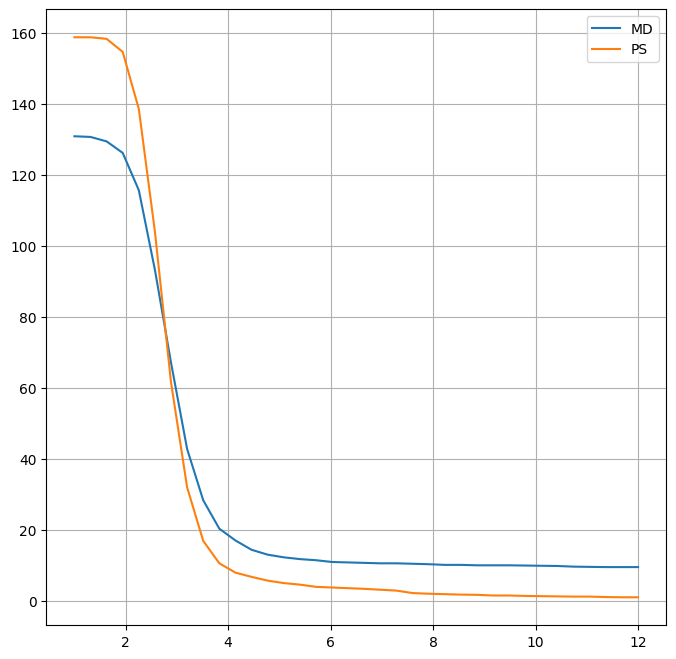

In [336]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(m_thrhlds, m_means, label='MD')
ax.plot(p_thrhlds, p_means, label='PS')
ax.grid()
ax.legend()

In [349]:
m_interp = scipy.interpolate.interp1d(m_thrhlds, m_means, kind='linear', fill_value="extrapolate")
p_interp = scipy.interpolate.interp1d(p_thrhlds, p_means, kind='linear', fill_value="extrapolate")

m_deriv = scipy.misc.derivative(m_interp, m_thrhlds, dx=1e-3)
p_deriv = scipy.misc.derivative(p_interp, m_thrhlds, dx=1e-3)

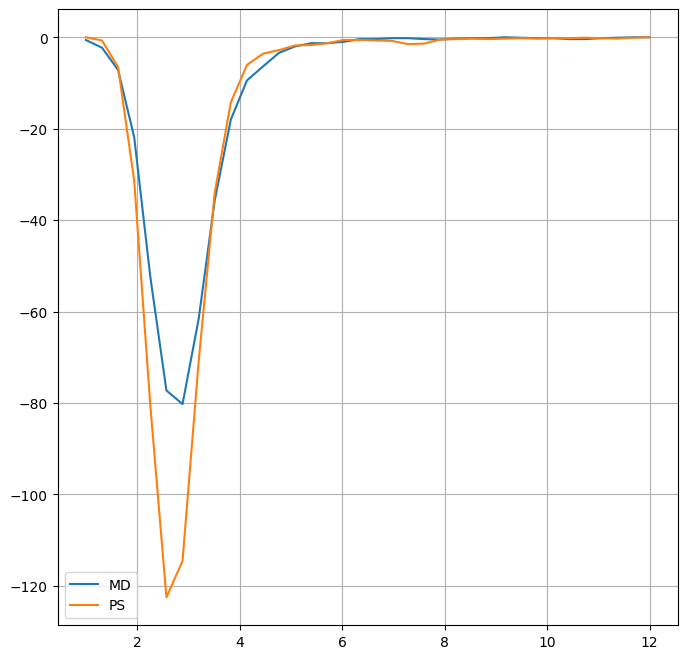

In [350]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(m_thrhlds, m_deriv, label='MD')
ax.plot(p_thrhlds, p_deriv, label='PS')
ax.grid()
ax.legend()

In [312]:
n = 200
M_scaled = M_crops[n]
P_crop = P_crops[n]

In [117]:
M_scaled -= M_scaled.min()
M_scaled /= M_scaled.max()
M_scaled *= 255

P_crop -= P_crop.min()
P_crop /= P_crop.max()
P_crop *= 255

In [118]:
M_data = im.fromarray((M_scaled).astype(np.uint8))
M_data.save('M_im.jpeg')
M_im = cv2.imread('M_im.jpeg')
M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

P_data = im.fromarray((P_crop).astype(np.uint8))
P_data.save('P_im.jpeg')
P_im = cv2.imread('P_im.jpeg')
P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

1


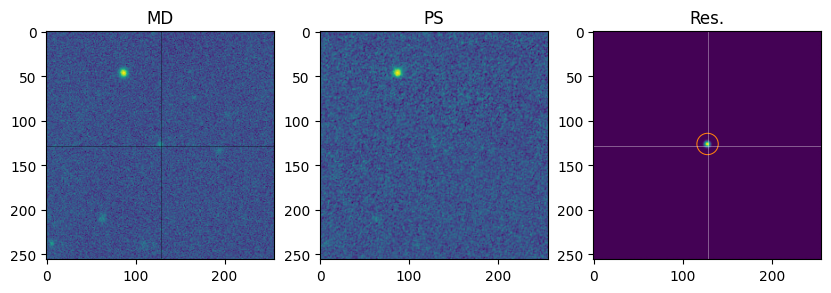

In [119]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(10, 10))

inp1 = cv2.dnn.blobFromImage(P_img, 1, (256,256))
inp2 = cv2.dnn.blobFromImage(M_img, 1, (256,256))

net.setInput(inp1, 'img0')
net.setInput(inp2, 'img1')

out = net.forward()
std = out.std()

# out[0][0][out[0][0] < np.sqrt(std)/100] = 0
# out[0][0][out[0][0] >= np.sqrt(std)/100] = 1

ax1.imshow(M_img)
ax1.axvline(x=128, alpha = .5, lw=.5, c='k')
ax1.axhline(y=128, alpha = .5, lw=.5, c='k')

ax1.set_title('MD')

ax2.imshow(P_img)
ax2.set_title('PS')

ax3.imshow(out[0][0])
ax3.axvline(x=128, alpha = .5, c='white', lw=.5)
ax3.axhline(y=128, alpha = .5, c='white', lw=.5)

ax3.set_title('Res.')

out_mean, out_median, out_std = sigma_clipped_stats(out[0][0])

out_threshold = out_median + (75*out_std)
out_tbl = find_peaks(out[0][0], out_threshold, box_size=25).as_array()

out_positions = np.transpose((out_tbl ['x_peak'], out_tbl ['y_peak']))
out_apertures = CircularAperture(out_positions, r=12.0)
a = out_apertures.plot(ax3, color='C1', lw=.75, alpha=1)
print(len(out_tbl))

In [ ]:
MD_PS = u.UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filts=128,
             activation='leaky',
             conv_mode='same',
             dim=2)

checkpoint_MD_PS = torch.load('checkpoints_MD_to_PS/model_10.pth.tar', map_location=config.DEVICE)
MD_PS.load_state_dict(checkpoint_MD_PS["state_dict"])

# device = 'cuda'
# model = model.to(device)

# summary(model, (1,1,256,256))

In [ ]:
PS_MD = u.UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filts=128,
             activation='leaky',
             conv_mode='same',
             dim=2)

checkpoint_PS_MD = torch.load('checkpoints_PS_to_MD/model_16.pth.tar', map_location=config.DEVICE)
PS_MD.load_state_dict(checkpoint_PS_MD["state_dict"])

# device = 'cuda'
# model = model.to(device)

# summary(model, (1,1,256,256))

In [6]:
%%time

for j in range(6,11):

    M_hdu = fits.open('data/prepro/'+str(j)+'_M.fits')[0]
    M_wcs = WCS(M_hdu.header)
    M = M_hdu.data
    P = fits.open('data/prepro/'+str(j)+'_P.fits')[0].data
    
    y = 128
    x = 128

    P_crops = []
    M_crops = []
    res = []
    numbers = []

    boffset, ps_median, bsoften = sigma_clipped_stats(M[200:1896, 200:1896], maxiters=0)

    while y < np.shape(M)[0]:

        while x < np.shape(M)[1]:

            try:
                M_crop, P_crop = M[y-128:y+128, x-128:x+128].copy(), P[y-128:y+128, x-128:x+128].copy()
                M_scaled = scale_M(25,
                          25,
                          M_crop,
                          P_crop,
                          bsoften,
                          boffset,)

            except ValueError:
                M_scaled = np.zeros((256,256))
                P_crop = np.zeros((256,256))
                out = np.zeros((256,256))
                print(x,y)

            try:

                M_scaled -= M_scaled.min()
                M_scaled /= M_scaled.max()
                M_scaled *= 255

                P_crop -= P_crop.min()
                P_crop /= P_crop.max()
                P_crop *= 255

                M_data = im.fromarray((M_scaled).astype(np.uint8))
                M_data.save('M_im.jpeg')
                M_im = cv2.imread('M_im.jpeg')
                M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

                P_data = im.fromarray((P_crop).astype(np.uint8))
                P_data.save('P_im.jpeg')
                P_im = cv2.imread('P_im.jpeg')
                P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

                inp1 = cv2.dnn.blobFromImage(P_img, 1, (256,256))
                inp2 = cv2.dnn.blobFromImage(M_img, 1, (256,256))

                net.setInput(inp1, 'img0')
                net.setInput(inp2, 'img1')

                out = net.forward()[0][0]

            except ValueError:
                M_scale = np.zeros((256,256))
                P_crop = np.zeros((256,256))
                out = np.zeros((256,256))

            M_crops.append(M_scaled)
            P_crops.append(P_crop)
            res.append(out)

            try:
                out_mean, out_median, out_std = sigma_clipped_stats(out)
                out_threshold = out_median + (75*out_std)
                out_tbl = find_peaks(out, out_threshold, box_size=25).as_array()
                numbers.append(len(out_tbl))

            except AttributeError:
                numbers.append(0)

            x += 256

        y += 256
        x = 128
        
    MM = np.concatenate((M_crops), axis=1)    
    PP = np.concatenate((P_crops), axis=1) 
    RR = np.concatenate((res), axis=1) 

    M_result = MM[:, 0: 4096]
    P_result = PP[:, 0: 4096]
    R_result = RR[:, 0: 4096]

    for k in range(1, 16):
        M_result = np.concatenate((M_result, MM[:, 4096*k:4096+4096*k]), axis=0)
        P_result = np.concatenate((P_result, PP[:, 4096*k:4096+4096*k]), axis=0)
        R_result = np.concatenate((R_result, RR[:, 4096*k:4096+4096*k]), axis=0)
        
    M_data = im.fromarray((M_result).astype(np.uint8))
    M_data.save('data/subtraction results/' + str(j) + '_M_result.jpeg')

    P_data = im.fromarray((P_result).astype(np.uint8))
    P_data.save('data/subtraction results/' + str(j) + '_P_result.jpeg')
    
    R_data = im.fromarray((R_result).astype(np.uint8))
    R_data.save('data/subtraction results/' + str(j) + '_R_result.jpeg')

    np.savetxt('data/subtraction results/' + str(j) + 'numbers.txt', np.array((numbers)))

Wall time: 1h 10min 36s


In [319]:
# %%time

# y = 128
# x = 128

# P_crops = []
# M_crops = []
# res = []
# numbers = []

# boffset, ps_median, bsoften = sigma_clipped_stats(M[200:1896, 200:1896], maxiters=0)

# while y < np.shape(M)[0]:
    
#     while x < np.shape(M)[1]:
        
#         try:
#             M_crop, P_crop = M[y-128:y+128, x-128:x+128].copy(), P[y-128:y+128, x-128:x+128].copy()
#             M_scaled = scale_M(25,
#                       25,
#                       M_crop,
#                       P_crop,
#                       bsoften,
#                       boffset,)
            
#         except ValueError:
#             M_scaled = np.zeros((256,256))
#             P_crop = np.zeros((256,256))
#             out = np.zeros((256,256))
#             print(x,y)
        
#         try:
            
#             M_scaled -= M_scaled.min()
#             M_scaled /= M_scaled.max()
#             M_scaled *= 255

#             P_crop -= P_crop.min()
#             P_crop /= P_crop.max()
#             P_crop *= 255
            
#             M_data = im.fromarray((M_scaled).astype(np.uint8))
#             M_data.save('M_im.jpeg')
#             M_im = cv2.imread('M_im.jpeg')
#             M_img = cv2.cvtColor(M_im, cv2.COLOR_BGR2GRAY)

#             P_data = im.fromarray((P_crop).astype(np.uint8))
#             P_data.save('P_im.jpeg')
#             P_im = cv2.imread('P_im.jpeg')
#             P_img = cv2.cvtColor(P_im, cv2.COLOR_BGR2GRAY)

#             inp1 = cv2.dnn.blobFromImage(P_img, 1, (256,256))
#             inp2 = cv2.dnn.blobFromImage(M_img, 1, (256,256))

#             net.setInput(inp1, 'img0')
#             net.setInput(inp2, 'img1')

#             out = net.forward()[0][0]
            
#         except ValueError:
#             M_scale = np.zeros((256,256))
#             P_crop = np.zeros((256,256))
#             out = np.zeros((256,256))
            
#         M_crops.append(M_scaled)
#         P_crops.append(P_crop)
#         res.append(out)
        
#         try:
#             out_mean, out_median, out_std = sigma_clipped_stats(out)
#             out_threshold = out_median + (75*out_std)
#             out_tbl = find_peaks(out, out_threshold, box_size=25).as_array()
#             numbers.append(len(out_tbl))
            
#         except AttributeError:
#             numbers.append(0)
        
#         x += 256
        
#     y += 256
#     x = 128

In [320]:
# fig, ax = plt.subplots(2,2,figsize=(8,10))

# n = 102

# ax[0][0].imshow(M_crops[n])
# ax[0][0].axvline(x=128, alpha=.5, lw=.5, c='k')
# ax[0][0].axhline(y=128, alpha=.5, lw=.5, c='k')

# ax[0][1].imshow(P_crops[n])

# a,b,c=ax[1][0].hist(M_crops[n].ravel(), bins=100)
# a,b,c=ax[1][1].hist(P_crops[n].ravel(), bins=100)

# m_nan_ratio = np.count_nonzero(1*np.isnan(M_crops[n].ravel())) / len(M_crops[n].ravel())*100
# p_nan_ratio = np.count_nonzero(1*np.isnan(P_crops[n].ravel())) / len(P_crops[n].ravel())*100

# print('Доля пропущенных значений MD: {}%'.format(m_nan_ratio))
# print('Доля пропущенных значений PS: {}%'.format(p_nan_ratio))

In [318]:
# MM = np.concatenate((M_crops), axis=1)    
# PP = np.concatenate((P_crops), axis=1) 
# RR = np.concatenate((res), axis=1) 

# M_result = MM[:, 0: 4096]
# P_result = PP[:, 0: 4096]
# R_result = RR[:, 0: 4096]

# for k in range(1, 16):
#     M_result = np.concatenate((M_result, MM[:, 4096*k:4096+4096*k]), axis=0)
#     P_result = np.concatenate((P_result, PP[:, 4096*k:4096+4096*k]), axis=0)
#     R_result = np.concatenate((R_result, RR[:, 4096*k:4096+4096*k]), axis=0)

In [17]:
i = 7

M_hdu = fits.open('data/prepro/'+str(i)+'_M.fits')[0]
M_wcs = WCS(M_hdu.header)
world = SkyCoord(M_hdu.header['RA'] + ' ' + M_hdu.header['DEC'], unit=(u.hourangle, u.deg))
grb = np.asarray(M_wcs.world_to_pixel(world))

# M_result = np.loadtxt('data/subtraction results/' + str(i) + '_M_result.jpeg')
# P_result = np.loadtxt('data/subtraction results/' + str(i) + '_P_result.jpeg')
# R_result = np.loadtxt('data/subtraction results/' + str(i) + '_R_result.jpeg')

M_res = cv2.imread('data/subtraction results/' + str(i) + '_M_result.jpeg')
M_result = cv2.cvtColor(M_res, cv2.COLOR_BGR2GRAY)

P_res = cv2.imread('data/subtraction results/' + str(i) + '_P_result.jpeg')
P_result = cv2.cvtColor(P_res, cv2.COLOR_BGR2GRAY)

R_res = cv2.imread('data/subtraction results/' + str(i) + '_R_result.jpeg')
R_result = cv2.cvtColor(R_res, cv2.COLOR_BGR2GRAY)

numbers = np.loadtxt('data/subtraction results/' + str(i) + 'numbers.txt')

In [18]:
sums = []
for i in range(11):
    numbers =  np.loadtxt('data/subtraction results/' + str(i) + 'numbers.txt')
    sums.append(np.sum(numbers))

In [19]:
sums

[768.0, 931.0, 979.0, 754.0, 734.0, 859.0, 497.0, 516.0, 713.0, 1009.0, 635.0]

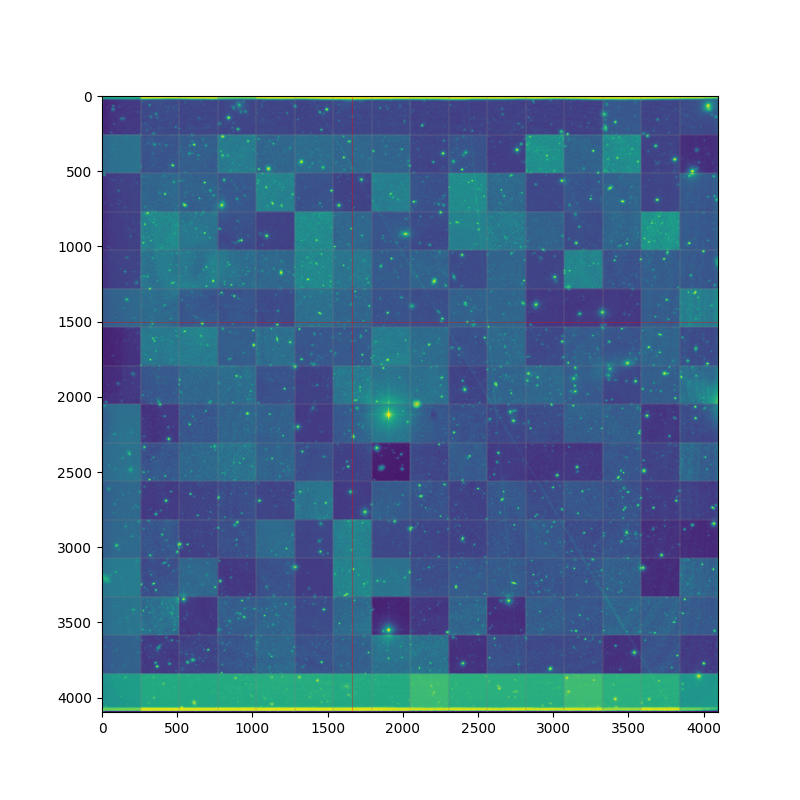

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(M_result)

ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

for i in range(16):
    ax.axvline(256*i, color='gray', lw=.25)
    ax.axhline(256*i, color='gray', lw=.25)

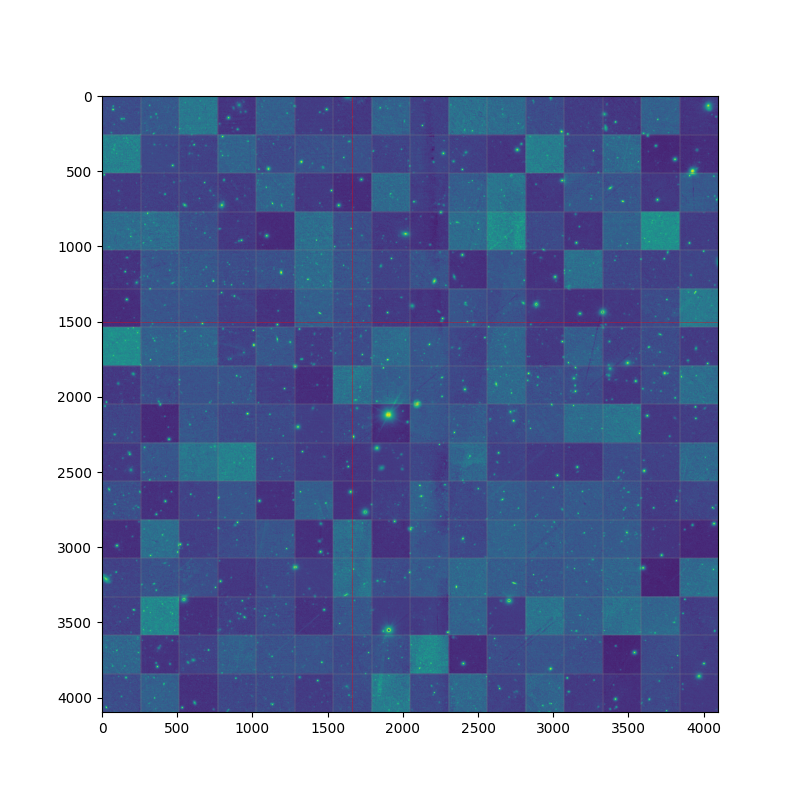

In [23]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(P_result)
ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

for i in range(16):
    ax.axvline(256*i, color='gray', lw=.25)
    ax.axhline(256*i, color='gray', lw=.25)

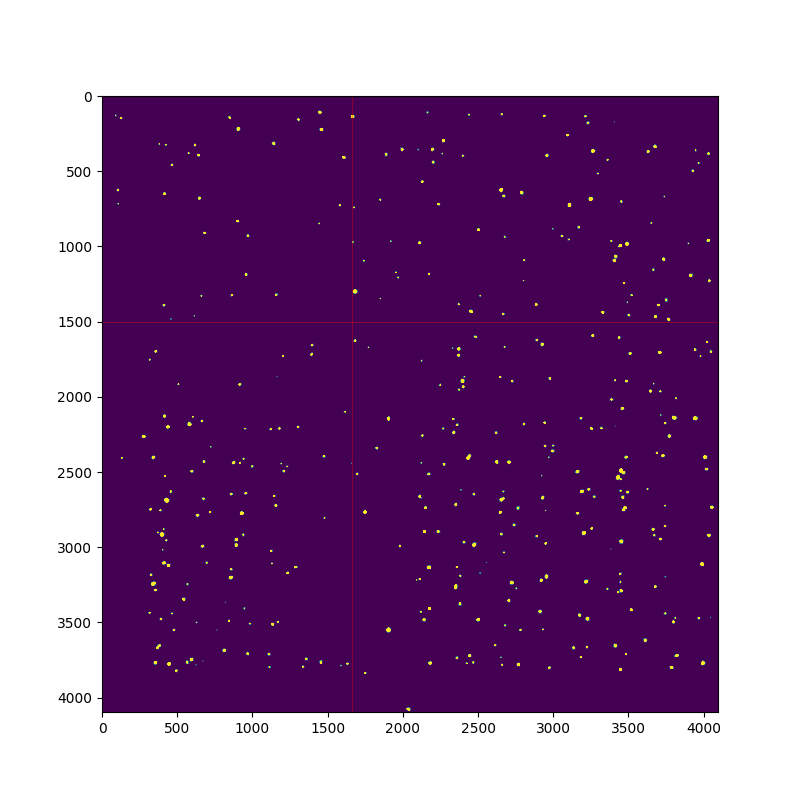

In [24]:
%matplotlib ipympl

fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(R_result, clim=(0,1))
ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

# for i in range(16):
#     ax.axvline(256*i, color='gray', lw=.25)
#     ax.axhline(256*i, color='gray', lw=.25)

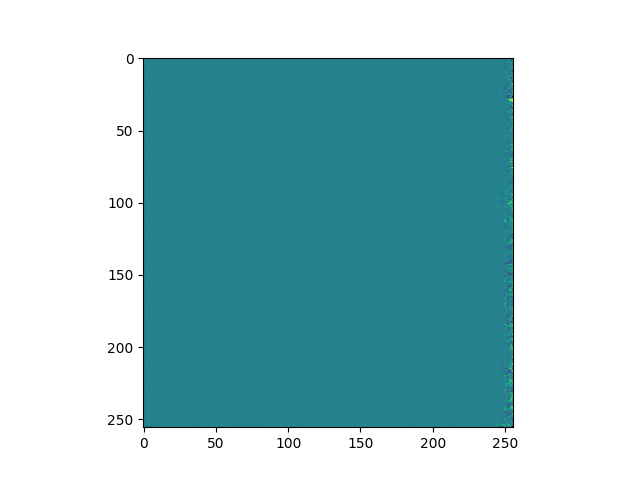

In [37]:
k = np.random.randint(0,256)
R_res = RR[:, 256*k: 256*k + 256]

fig, ax = plt.subplots()
ax.imshow(R_res)

In [38]:
R_mean, R_median, R_std = sigma_clipped_stats(R_result, sigma=5.0)
R_threshold = R_median + (100*R_std)
R_tbl = find_peaks(R_result, R_threshold, box_size=25).as_array()

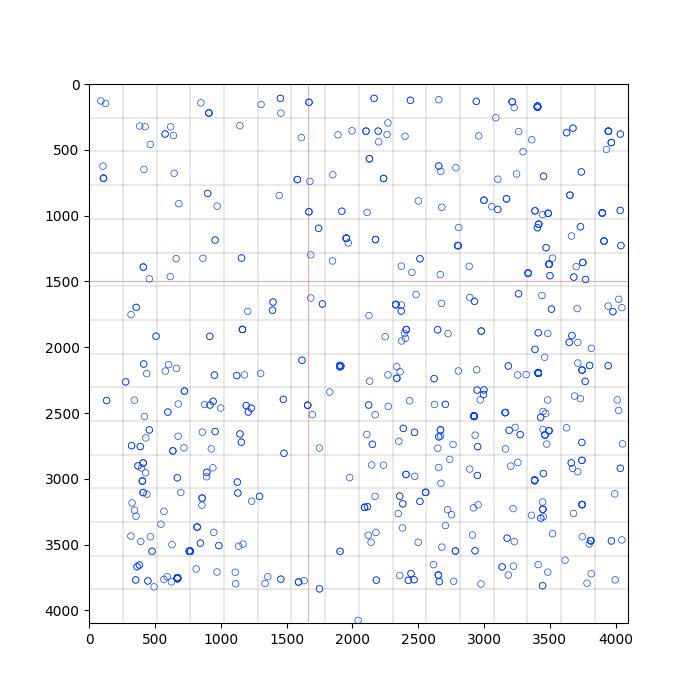

In [39]:
%matplotlib ipympl

fig, ax = plt.subplots(figsize=(7,7))

positions = np.transpose((R_tbl ['x_peak'], R_tbl ['y_peak']))
apertures = CircularAperture(positions, r=25.0)

ax.imshow(R_result, cmap='Greys')

apertures.plot(color='#0547f9', lw=.5)

ax.axvline(grb[0], alpha = .5, lw=.5, c='r')
ax.axhline(grb[1], alpha = .5, lw=.5, c='r')

for i in range(16):
    ax.axvline(256*i, color='gray', lw=.25)
    ax.axhline(256*i, color='gray', lw=.25)

In [384]:
np.sum(numbers)

734.0

In [10]:
k = 1

x = 3500
y = 3500

# M = fits.open('data/prepro/'+str(k)+'_M.fits')[0].data[y-256:y+255, x-256:x+255]
# P = fits.open('data/prepro/'+str(k)+'_P.fits')[0].data[y-256:y+255, x-256:x+255]

mu_M = np.nanmean(M)
sigma_M = np.nanstd(M)

a_M = 1/(6*sigma_M)
b_M = 1/2 - mu/(6*sigma_M)

mu_P = np.nanmean(P)
sigma_P = np.nanstd(P)

a_P = 1/(6*sigma_P)
b_P = 1/2 - mu/(6*sigma_P)

M_upd = a_M*M+b_M
P_upd = a_P*P+b_P

NameError: name 'mu' is not defined

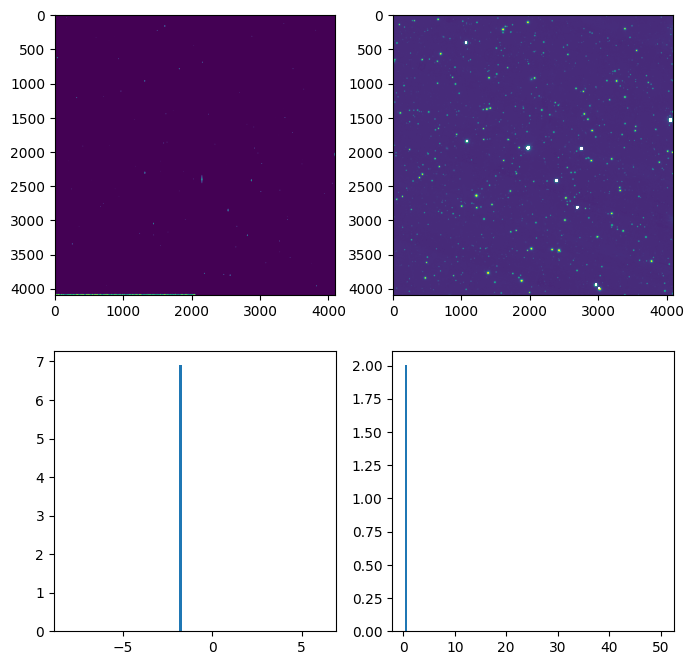

In [252]:
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0][0].imshow(np.clip(M_upd, 0, 0.5))
ax[0][1].imshow(np.clip(P_upd, 0, 0.5))

a,b,c=ax[1][0].hist(M_upd.ravel(), bins=100, density=True)
a,b,c=ax[1][1].hist(P_upd.ravel(), bins=100, density=True)

# ax[1][0].set_xlim(0,1)

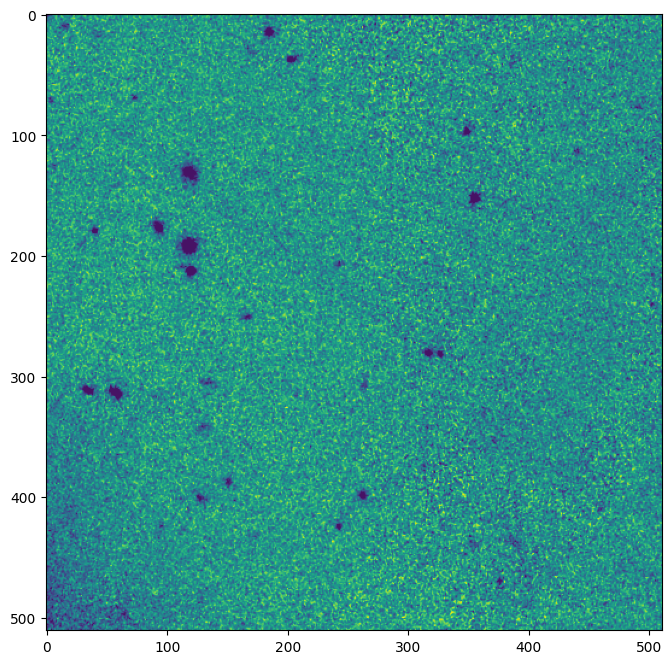

In [171]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(np.clip(M_upd, 0, 0.5)-np.clip(P_upd, -1, 1))

In [460]:
def plot_pair(j, y, x):

    md_im = np.array((fits.getdata('data/PrePro/' + str(j) + '_M.fits'))).astype(float)

    md_im -= np.nanmin(md_im)
    md_im /= np.nanmax(md_im)
    md_im = 2*md_im - 1           #-1 to 1 mapping

    ps_im = np.array((fits.getdata('data/PrePro/' + str(j) + '_P.fits'))).astype(float)

    ps_im -= np.nanmin(ps_im)
    ps_im /= np.nanmax(ps_im)
    ps_im = 2*ps_im - 1

    md_crop = md_im[y-26:y+25, x-26:x+25]
    ps_crop = ps_im[y-26:y+25, x-26:x+25]
    
    plots = []
    plots.append(md_crop)
    plots.append(ps_crop)

    fig = plt.figure(figsize=(10, 20))
    columns = 2
    rows = 1

    for i in range(columns*rows):
        img = plots[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        
    md_mean, md_median, md_std = sigma_clipped_stats(md_crop, sigma=5.0)
    ps_mean, ps_median, ps_std = sigma_clipped_stats(ps_crop, sigma=5.0)

    md_threshold = md_median + (5 * md_std)
    ps_threshold = ps_median + (5 * ps_std)
    
    try:
        md_tbl = find_peaks(md_crop, md_threshold, box_size=20).as_array()
        ps_tbl = find_peaks(ps_crop, ps_threshold, box_size=20).as_array()
        
        if len(md_tbl) == len(ps_tbl):
            print('Ok', len(md_tbl), len(ps_tbl))
        else:
            print('Not Ok', len(md_tbl), len(ps_tbl))
        
    except AttributeError:
        print('No detection')
         
    plt.show()

Ok 1 1


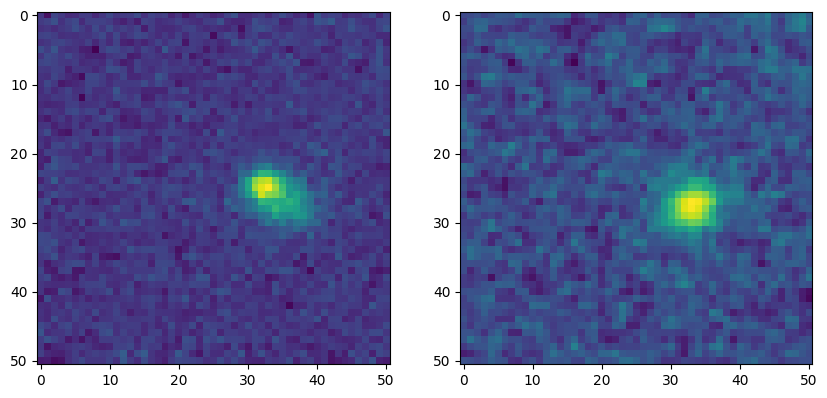

In [466]:
plot_pair(5, 101, 110)

In [469]:
data_list = os.listdir('data/PrePro') 

n = 0
n1 = 0
n2 = 0

for j, i in enumerate(data_list):
    
    if j == 13:
        break

    md_im = np.array((fits.getdata('data/PrePro/' + str(j) + '_M.fits'))).astype(float)           #-1 to 1 mapping
    ps_im = np.array((fits.getdata('data/PrePro/' + str(j) + '_P.fits'))).astype(float)

    y = 150
    x = 150

    while y < np.shape(md_im)[1] - 150:
        while x < np.shape(md_im)[0] - 150:
            
            md_crop = md_im[y-26:y+25, x-26:x+25]
            ps_crop = ps_im[y-26:y+25, x-26:x+25]
            
            md_mean, md_median, md_std = sigma_clipped_stats(md_crop, sigma=5.0)
            ps_mean, ps_median, ps_std = sigma_clipped_stats(ps_crop, sigma=5.0)

            md_threshold = md_median + (5.0 * md_std)
            ps_threshold = ps_median + (5.0 * ps_std)

            try:
                md_tbl = find_peaks(md_crop, md_threshold, box_size=10).as_array()
                ps_tbl = find_peaks(ps_crop, ps_threshold, box_size=10).as_array()

                if len(md_tbl) == len(ps_tbl):
                    
                    md_crop -= np.nanmin(md_crop)   #-1 to 1 mapping 
                    md_crop /= np.nanmax(md_crop)
                    md_crop = 2*md_crop - 1
                    
                    ps_crop -= np.nanmin(ps_crop)
                    ps_crop /= np.nanmax(ps_crop)
                    ps_crop = 2*ps_crop - 1
                    
                    im = np.concatenate((md_crop, ps_crop), axis=1)
                    
                    if np.isnan(im).any():
                        pass

                    else:
                        
                        if n % 2 == 0:
                            
                            np.savetxt('data2/train/' + str(n2)+ '.txt', im)
                            n2 += 1
                            
                            im90 = np.concatenate((np.rot90(md_crop, k=1),
                                                   np.rot90(ps_crop, k=1)),
                                                   axis=1)

                            np.savetxt('data2/train/' + str(n2)+ '.txt', im90)
                            n2 += 1
                            
                            im180 = np.concatenate((np.rot90(md_crop, k=2),
                                                   np.rot90(ps_crop, k=2)),
                                                   axis=1)
                            
                            np.savetxt('data2/train/' + str(n2)+ '.txt', im180)
                            n2 += 1
                            
                            im270 = np.concatenate((np.rot90(md_crop, k=2),
                                                   np.rot90(ps_crop, k=2)),
                                                   axis=1)
                            
                            np.savetxt('data2/train/' + str(n2)+ '.txt', im270)
                            n2 += 1
                        
                        else:
                            np.savetxt('data2/val/' + str(n1)+ '.txt', im)
                            n1 += 1   
                            
                            im90 = np.concatenate((np.rot90(md_crop, k=1),
                                                   np.rot90(ps_crop, k=1)),
                                                   axis=1)

                            np.savetxt('data2/val/' + str(n1)+ '.txt', im90)
                            n1 += 1
                            
                            im180 = np.concatenate((np.rot90(md_crop, k=2),
                                                   np.rot90(ps_crop, k=2)),
                                                   axis=1)
                            
                            np.savetxt('data2/val/' + str(n1)+ '.txt', im180)
                            n1 += 1
                            
                            im270 = np.concatenate((np.rot90(md_crop, k=2),
                                                   np.rot90(ps_crop, k=2)),
                                                   axis=1)
                            
                            np.savetxt('data2/val/' + str(n1)+ '.txt', im270)
                            n1 += 1
                            
                        n += 1
                        
                else:
                    pass

            except AttributeError:
                pass
                
            x += 51

        y += 51
        x = 150

In [510]:
def check_pair(j):

    im = np.loadtxt('data2/val/' + str(j) + '.txt').astype(float)

    md_im = im[:, :51]
    ps_im = im[:, 51:]

    plots = []
    plots.append(md_im)
    plots.append(ps_im)

    fig = plt.figure(figsize=(5, 10))
    columns = 2
    rows = 1

    for i in range(columns*rows):
        img = plots[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        
    plt.show()

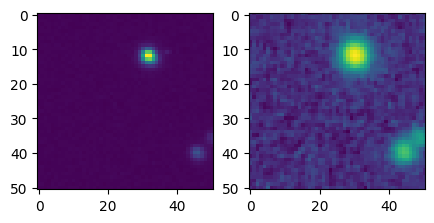

In [534]:
check_pair(np.random.randint(0,len(os.listdir('data2/val/'))))

In [470]:
len(os.listdir('data2/val/'))

21708

In [ ]:
# %matplotlib ipympl

# fig = plt.figure(figsize=(7, 4))
# ax_3d = fig.add_subplot(projection='3d')

# x = np.arange(0, 256)
# y = np.arange(0, 256)
# xgrid, ygrid = np.meshgrid(x, y)
# zgrid = M_scaled

# ax_3d.plot_wireframe(xgrid, ygrid, zgrid, lw=.1)

In [ ]:
# %%time

# for k in range(12):
    
#     P = fits.open('data/prepro_old/'+str(k)+'_P.fits')[0].data
    
#     data = P
#     mask = np.where(~np.isnan(data))
#     interp = NearestNDInterpolator(np.transpose(mask), data[mask])
#     filled_data = interp(*np.indices(data.shape))
    
#     hdu = fits.PrimaryHDU(filled_data)
#     hdu.writeto('data/prepro/'+str(k)+'_P'+'.fits', overwrite=True)

In [ ]:
# %%time 

# for k in range(10):
    
#     M_hdu = fits.open('data/prepro/'+str(k)+'_M.fits')[0]
#     M_wcs = WCS(M_hdu.header)
#     M = M_hdu.data
#     P = fits.open('data/prepro/'+str(k)+'_P.fits')[0].data
#     world = SkyCoord(M_hdu.header['RA'] + ' ' + M_hdu.header['DEC'], unit=(u.hourangle, u.deg))
#     grb = np.asarray(M_wcs.world_to_pixel(world))
    
#     boffset, ps_median, bsoften = sigma_clipped_stats(M[200:3696, 200:3696].copy(), maxiters=0)

#     for m in range(100):

#         x0 = np.random.randint(400,3696)
#         y0 = np.random.randint(400,3696)

#         while (x0 - grb[1] < 150) or (y0 - grb[0] < 150):
#             x0 = np.random.randint(400,3696)
#             y0 = np.random.randint(400,3696)

#         M_crop = M[x0-128:x0+128, y0-128:y0+128].copy()
#         P_crop = P[x0-128:x0+128, y0-128:y0+128].copy()

#         M_scaled = scale_M(16,
#                   64,
#                   M_crop,
#                   P_crop,
#                   bsoften,
#                   boffset,)

#         im = np.concatenate((M_scaled, P_crop), axis=1)
#         np.savetxt('data/train/' + str(100*k + m)+ '.txt', im)